# Earthquake_real
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium
from IPython.display import HTML

In [3]:
def show(fig): 
    return HTML(fig.to_html(include_plotlyjs='cdn',include_mathjax=False, config=dict({'scrollZoom':False})))

In [4]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [5]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2000"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/01/2000,-60.7220,153.6700,6.0,2000
1,01/02/2000,-17.9430,-178.4760,5.5,2000
2,01/02/2000,51.4470,-175.5580,5.8,2000
3,01/02/2000,-20.7710,-174.2360,5.8,2000
4,01/05/2000,-20.9640,-174.0970,5.6,2000
...,...,...,...,...,...
8739,12/28/2016,38.3917,-118.8941,5.6,2016
8740,12/28/2016,38.3777,-118.8957,5.5,2016
8741,12/28/2016,36.9179,140.4262,5.9,2016
8742,12/29/2016,-9.0283,118.6639,6.3,2016


<AxesSubplot:>

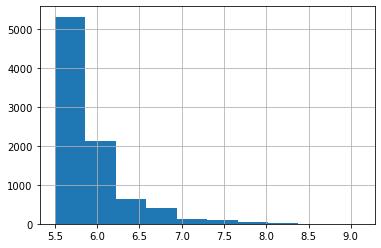

In [6]:
_df.Magnitude.hist()

##### 2. $f(x) = y + \epsilon$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [7]:
f = _df.loc[:,"Magnitude"]

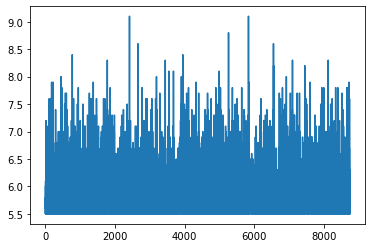

In [8]:
plt.plot(f,'-')

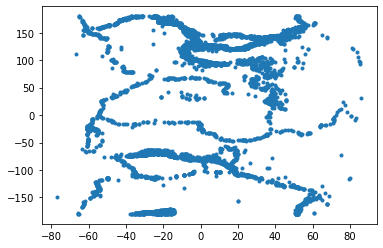

In [9]:
plt.plot( _df.Latitude,_df.Longitude,'.')

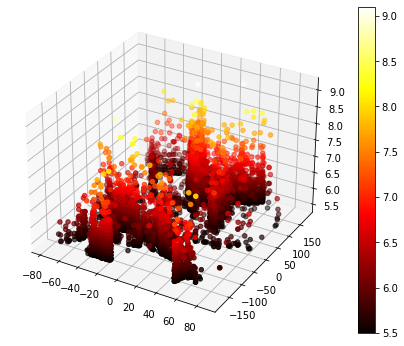

In [10]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude, c= _df.Magnitude,  cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [11]:
_dfgraph = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2000"').reset_index().iloc[:,1:].reset_index()

/tmp/ipykernel_162733/2573661339.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(_dfgraph.Year)


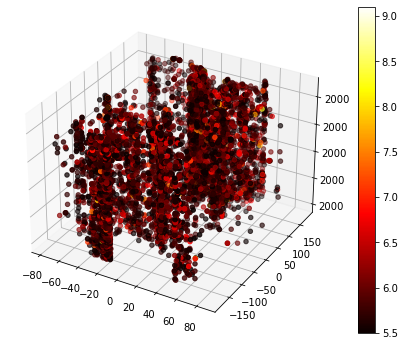

In [12]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_zticklabels(_dfgraph.Year)
img = ax.scatter(_dfgraph.Latitude, _dfgraph.Longitude, _dfgraph.index,c= _dfgraph.Magnitude, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [13]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [14]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [15]:
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(2000,2016))).add_to(m)
m

##### 3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2+(y_j-y_i)^2}$$

In [16]:
def dist(i,j):
    if abs( _df.Latitude[j] - _df.Latitude[i] ) > 90: 
        return 10000  
    elif abs( _df.Longitude[j] - _df.Longitude[i] ) > 90: 
        return 10000
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

##### 4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1)
- 연결강도로 생각

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [17]:
def weight(i,j,theta=150,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [18]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [19]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.844, 0.953, 0.842],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , ..., 0.996, 0.935, 0.996],
       ...,
       [0.844, 0.   , 0.996, ..., 1.   , 0.944, 1.   ],
       [0.953, 0.   , 0.935, ..., 0.944, 1.   , 0.942],
       [0.842, 0.   , 0.996, ..., 1.   , 0.942, 1.   ]])

(array([123600.,      0.,      0.,      0.,      0.,      0.,      0.,
          2006.,  22192.,  72163.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

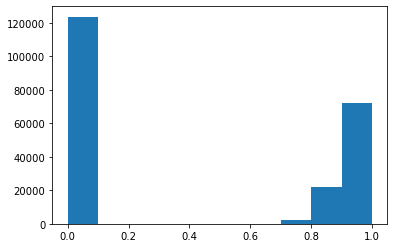

In [20]:
plt.hist(W.reshape(-1))

그래프

링크의 방향성이 없는 네트워크 nx.Graph

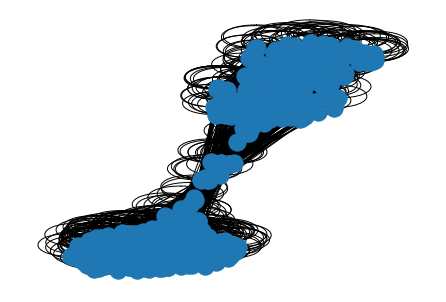

In [21]:
nx.draw(nx.Graph(W))
# 저장하고 싶으면
# plt.show(
# plt.savefig("networkGraph.png")

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [22]:
D = np.diag(W.sum(axis=1))

In [23]:
D

array([[230.82339832,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  96.79973509,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 238.50017704, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 247.32151479,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        261.59296085,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 247.14069666]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [24]:
L = D - W

In [25]:
L

array([[229.82339832,   0.        ,   0.        , ...,  -0.84361044,
         -0.95320388,  -0.84198116],
       [  0.        ,  95.79973509,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 237.50017704, ...,  -0.996181  ,
         -0.93497924,  -0.9958651 ],
       ...,
       [ -0.84361044,   0.        ,  -0.996181  , ..., 246.32151479,
         -0.94418167,  -0.99997337],
       [ -0.95320388,   0.        ,  -0.93497924, ...,  -0.94418167,
        260.59296085,  -0.94233531],
       [ -0.84198116,   0.        ,  -0.9958651 , ...,  -0.99997337,
         -0.94233531, 246.14069666]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$
- $\Psi^\top \Psi = I$

In [26]:
λ, Ψ = np.linalg.eig(L)

In [27]:
Λ = np.diag(λ)

##### 8. p
- $compk = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
- $p = (sum(comp1^2),sum(comp2^2),…,sum(comp8000^2))$
- $p = p/sum(p)$
    - 0.2 0.1  ...
- —> 5개의 최상의 컴포넌트만 골랐더니 70%

https://greeksharifa.github.io/machine_learning/2021/08/14/GFT/

https://ahjeong.tistory.com/14

In [28]:
def comp(i):
    return (f @ np.outer( Ψ[:,i], Ψ[:,i]))

In [29]:
def p(i):
    return sum(comp(i)**2)

In [30]:
p(0)

16286.266071641667

In [31]:
array_1 = np.array([p(i) for i in range(1,len(_df))])

In [32]:
varprop = array_1/array_1.sum()

In [41]:
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [44]:
_indexlst

[418,
 385,
 467,
 106,
 455,
 221,
 140,
 269,
 274,
 114,
 466,
 67,
 222,
 85,
 330,
 125,
 297,
 252,
 75,
 284,
 454,
 434,
 362,
 55,
 285]

(0.0, 40.0)

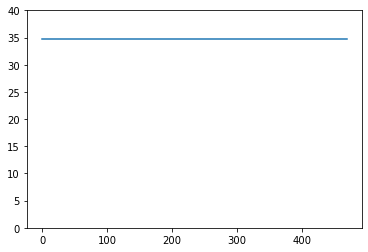

In [49]:
plt.plot( (f @ np.outer( Ψ[:,0], Ψ[:,0]))**2)
plt.ylim(0,40)

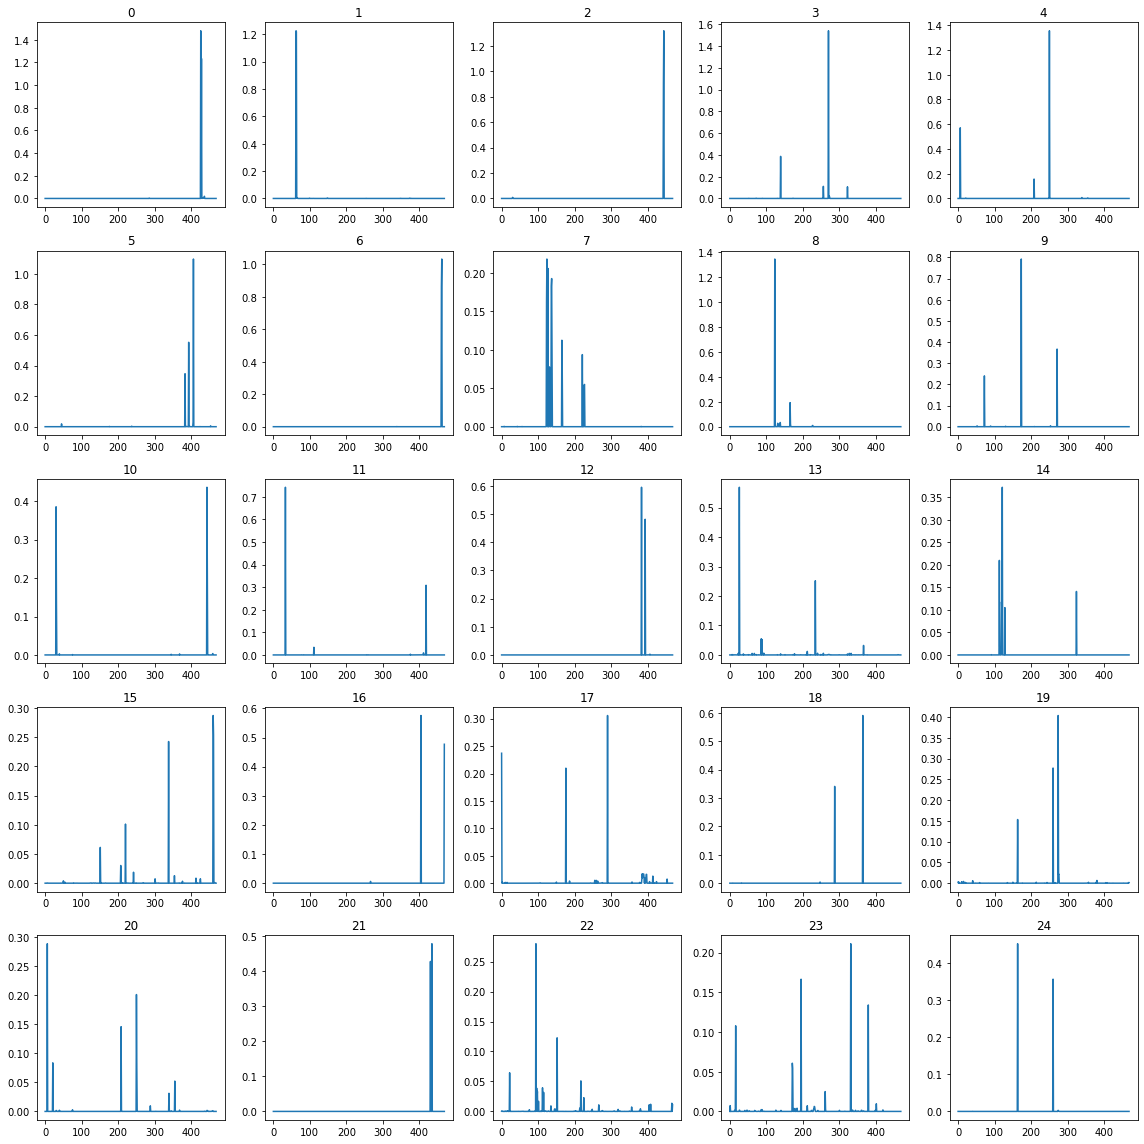

In [46]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,_indexlst[k]], Ψ[:,_indexlst[k]]))**2)
        # ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

---

GCN

In [ ]:
def g(i):
    return np.exp(-5*λ[i])

In [ ]:
g_i = np.array([g(i) for i in range(len(_df))])

In [ ]:
plt.plot(g_i)

In [ ]:
sum(g(0)*(f @ np.outer( Ψ[:,0], Ψ[:,0]))*Ψ[:,0])

---

##### 9. PCA

In [50]:
comp1 = f @ np.outer( Ψ[:,0], Ψ[:,0])

In [51]:
comp2 = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])

In [52]:
comp3 = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])

In [53]:
comp4 = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])

In [54]:
comp5 = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])

In [55]:
___df = _df

In [56]:
___df["comp1"] = comp1

In [57]:
___df["comp2"] = comp2

In [58]:
___df["comp3"] = comp3

In [59]:
___df["comp4"] = comp4

In [60]:
___df["comp5"] = comp5

In [61]:
#collapse
_lst=[___df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [62]:
#collapse
__lst1=[___df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,5]].\
to_numpy().tolist() for i in range(2016-2000)]

In [65]:
#collapse
__lst2=[___df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,6]].\
to_numpy().tolist() for i in range(2016-2000)]

In [66]:
#collapse
__lst3=[___df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,7]].\
to_numpy().tolist() for i in range(2016-2000)]

In [67]:
#collapse
__lst4=[___df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,8]].\
to_numpy().tolist() for i in range(2016-2000)]

In [68]:
#collapse
__lst5=[___df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,9]].\
to_numpy().tolist() for i in range(2016-2000)]

In [70]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [73]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst2,radius=50,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [74]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst3,radius=50,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [75]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst4,radius=50,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [76]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst5,radius=50,index=list(range(2000,2016))).add_to(_m)
_m